In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy, pickle
import matplotlib

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_wc
from neurolib.optimal_control import cost_functions as cost_functions
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_singlenode
import scipy

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

# We define colors for later convenience
color_x = 'red'
color_y = 'blue'
fs_=16
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.titlesize"] = fs_
plt.rcParams["axes.labelsize"] = fs_
matplotlib.rc('xtick', labelsize=fs_) 
matplotlib.rc('ytick', labelsize=fs_) 
plt.rc('legend',fontsize=fs_)

period =  18.900000000000002
minima =  [  23  211  400  589  778  967 1156 1345 1534 1723 1912 2101 2290 2479
 2668 2857]


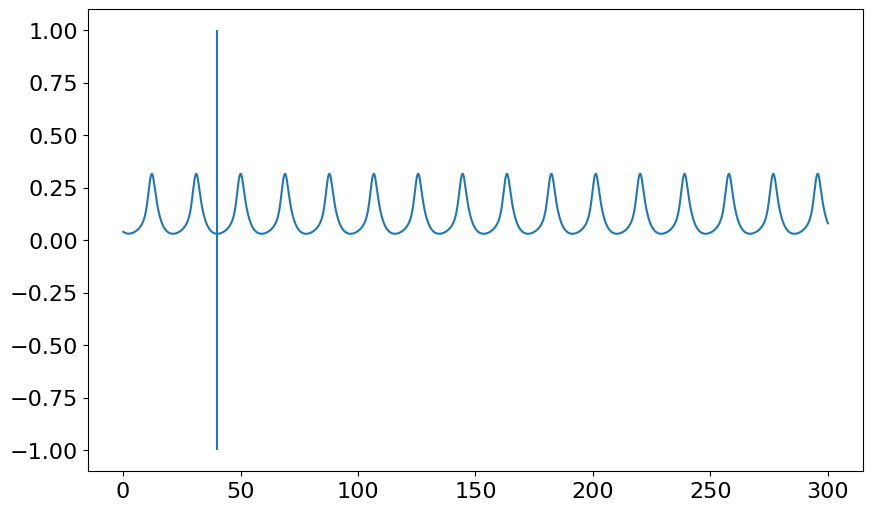

In [2]:
wc = WCModel()
wc.params.sigma_ou = 0.

dt = 0.1
wc.params.dt = dt

duration = 300.
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
zero_control =np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]
input = zero_control.copy()

wc.params["duration"] = duration
x_init = 0.045135938287846025
y_init = 0.08586538415443892
wc.params["exc_init"] = np.array([[x_init]])
wc.params["inh_init"] = np.array([[y_init]])

wc.params["exc_ext"] = zero_input + 1.
wc.params["inh_ext"] = zero_input

wc.run()

peaks = scipy.signal.find_peaks(wc.exc[0,:])[0]
period = (peaks[-1] - peaks[-2])*dt
print("period = ", period)

wc.run()
init_min = [wc.exc[0,174], wc.inh[0,174]]

wc.params["exc_init"] = np.array([[init_min[0]]])
wc.params["inh_init"] = np.array([[init_min[1]]])
wc.run()
target_min = np.concatenate((np.concatenate( (wc.params["exc_init"], wc.params["inh_init"]), axis=1)[:,:, np.newaxis], np.stack( (wc.exc, wc.inh), axis=1)), axis=2)

mins = scipy.signal.find_peaks(-wc.exc[0,:])[0]
print("minima = ", mins)

plt.plot(wc.t, wc.exc[0,:])
plt.vlines(40,-1,1)
plt.show()

In [3]:
control_mat = np.zeros( (wc.params.N, len(wc.state_vars)) )
control_mat[0,0] = 1.
control_mat[0,1] = 1.

prec_mat = np.zeros( (wc.params.N, len(wc.output_vars)) )
prec_mat[0,0] = 1.
prec_mat[0,1] = 1.

int0, int1 = 400, None

duration = 80.
wc.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
zero_control =np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]

wc.params["exc_ext"] = zero_input + 1.
wc.params["inh_ext"] = zero_input

In [4]:
def increase_step_compute():
    wc_controlled.step = 1e-2
    wc_controlled.zero_step_encountered = False
    wc_controlled.optimize(200)

    wc_controlled.step = 1e-1
    wc_controlled.zero_step_encountered = False
    wc_controlled.optimize(200)

    wc_controlled.step = 1e0
    wc_controlled.zero_step_encountered = False
    wc_controlled.optimize(400)
    
    wc_controlled.step = 1e1
    wc_controlled.zero_step_encountered = False
    wc_controlled.optimize(1000)

    return

def get_values(results_dict, iw, ish, w1):
    results_dict["control"][iw][ish] = wc_controlled.control.copy()
    results_dict["state"][iw][ish] = wc_controlled.get_xs().copy()
    results_dict["total_cost"][iw][ish] = wc_controlled.cost_history[-1]

    wc_controlled.w_1D = 0.
    wc_controlled.simulate_forward()
    results_dict["precision_cost"][iw][ish] = wc_controlled.compute_total_cost()
    results_dict["L1_cost_weighted"][iw][ish] = ( results_dict["total_cost"][iw][ish] - results_dict["precision_cost"][iw][ish]) 
    results_dict["L1_cost_unweighted"][iw][ish] = results_dict["L1_cost_weighted"][iw][ish] / w1
    wc_controlled.w_1D = w1

    return

def get_period_index_target(period, i_sh, n_points, target_in):
    p = i_sh* 2.* np.pi / (n_points-1)
    index = np.round(p * period/ ( 2. * np.pi)/ dt).astype(int)
    target = target_in[:,:,index:index+np.round(1+duration/dt,1).astype(int)]

    return p, index, target

def getmodel(target_shift, w1, results_dict, iw, ish):
    wc_controlled = oc_wc.OcWc(wc, target=target_shift, w_p=1, w_2=0., w_1D=w1, print_array=np.arange(0,2001,200), precision_cost_interval=(int0,int1), control_matrix=control_mat, precision_matrix=prec_mat)

    if type(results_dict["control"][iw][ish]) != type(None):
        wc_controlled.control = results_dict["control"][iw][ish].copy()
        wc_controlled.update_input()
    wc_controlled.model.run()    

    return wc_controlled

In [5]:
n_points = 41
w_array = [0.25, 1., 4.]
none_array = [[None] * n_points, [None] * n_points, [None] * n_points ]
file_array = ["0-25_min_w1.png", "1_min_w1.png", "4_min_w1.png"]

results_min = dict([
    ('w1', w_array),
    ("total_cost", [[None] * n_points, [None] * n_points, [None] * n_points ]),
    ("initial_cost", [[None] * n_points, [None] * n_points, [None] * n_points ]),
    ("precision_cost", [[None] * n_points, [None] * n_points, [None] * n_points ]),
    ("L1_cost_unweighted", [[None] * n_points, [None] * n_points, [None] * n_points ]),
    ("L1_cost_weighted", [[None] * n_points, [None] * n_points, [None] * n_points ]),
    ("control", [[None] * n_points, [None] * n_points, [None] * n_points ]),
    ("state", [[None] * n_points, [None] * n_points, [None] * n_points ]),
    ("filename", file_array)
    ])

In [6]:
def save(results_dict):
    filehandler = open("results_min_w1.pickle","wb")
    pickle.dump(results_dict,filehandler)
    filehandler.close()

def read():
    filehandler = open("results_min_w1.pickle","rb")
    results_dict = pickle.load(filehandler)
    filehandler.close()

    return results_dict

def readfile(file):
    filehandler = open(file,"rb")
    results_dict = pickle.load(filehandler)
    filehandler.close()

    return results_dict

In [7]:
results_min = read()
results_peak = readfile("results_peak_w1.pickle")

In [8]:
wc.params["exc_init"] = np.array([[init_min[0]]])
wc.params["inh_init"] = np.array([[init_min[1]]])

ind_list = range(41)
#options = [False, False, False, False, False, False, False, False]
options = [True, True, True, True, True, True, True, True]

for k in range(1):

    for i_w in range(len(results_min["w1"])):

        if i_w in [0,2]:
            continue

        w1 = results_min['w1'][i_w]

        for i_shift in range(n_points):

            break
            
            if type(results_min["control"][i_w][i_shift]) != type(None):
                continue

            period_shift, index_shift, target_shift = get_period_index_target(period, i_shift, n_points, target_min)
            wc_controlled = getmodel(target_shift, w1, results_min, i_w, i_shift)

            wc_controlled.step = 1e-3
            wc_controlled.optimize(1)

            results_min["initial_cost"][i_w][i_shift] = wc_controlled.cost_history[0]

            wc_controlled.step = 1e-3
            wc_controlled.optimize(200)

            if i_shift in [0, n_points-1]:
                get_values(results_min, i_w, i_shift, w1)
                continue

            increase_step_compute()
            get_values(results_min, i_w, i_shift, w1)

        if options[0]:
            print("----------------------------------------------- 0")
            for i_shift in range(2, n_points-1):

                if i_shift not in ind_list:
                    continue

                period_shift, index_shift, target_shift = get_period_index_target(period, i_shift, n_points, target_min)
                wc_controlled = getmodel(target_shift, w1, results_min, i_w, i_shift)
                
                factor = 0.8 + 0.5*np.random.random()
                
                wc_controlled.control = results_min["control"][i_w][i_shift-1].copy() * factor
                wc_controlled.update_input()

                wc_controlled.step = 1e-3
                wc_controlled.zero_step_encountered = False
                wc_controlled.optimize(200)

                increase_step_compute()

                if wc_controlled.cost_history[-1] < results_min["total_cost"][i_w][i_shift]:
                    print("-----------------------------------------------")
                    print("0 found better solution, ", i_shift)

                    get_values(results_min, i_w, i_shift, w1)

        if options[1]:
            print("----------------------------------------------- 1")
            for i_shift in range(n_points-3, 0, -1):

                if i_shift not in ind_list:
                    continue

                period_shift, index_shift, target_shift = get_period_index_target(period, i_shift, n_points, target_min)
                wc_controlled = getmodel(target_shift, w1, results_min, i_w, i_shift)

                factor = 0.8 + 0.5*np.random.random()
                
                wc_controlled.control = results_min["control"][i_w][i_shift+1].copy() * factor
                wc_controlled.update_input()
                wc_controlled.simulate_forward()

                increase_step_compute()

                if wc_controlled.cost_history[-1] < results_min["total_cost"][i_w][i_shift]:
                    print("-----------------------------------------------")
                    print("1 found better solution, ", i_shift)

                    get_values(results_min, i_w, i_shift, w1)

        if options[2]:
            print("----------------------------------------------- 2")
            for i_shift in range(1, n_points-1):

                if i_shift not in ind_list:
                    continue

                period_shift, index_shift, target_shift = get_period_index_target(period, i_shift, n_points, target_min)
                wc_controlled = getmodel(target_shift, w1, results_min, i_w, i_shift)
                            
                wc_controlled.control = results_min["control"][i_w-1][i_shift].copy() * (0.95*np.random.random()*0.1)
                wc_controlled.update_input()

                wc_controlled.step = 1e-3
                wc_controlled.zero_step_encountered = False
                wc_controlled.optimize(200)

                increase_step_compute()

                if wc_controlled.cost_history[-1] < results_min["total_cost"][i_w][i_shift]:
                    print("-----------------------------------------------")
                    print("2 found better solution, ", i_shift)

                    get_values(results_min, i_w, i_shift, w1)

        if options[3]:
            print("----------------------------------------------- 3")
            for i_shift in range(1, n_points-1):

                if i_shift not in ind_list:
                    continue

                period_shift, index_shift, target_shift = get_period_index_target(period, i_shift, n_points, target_min)
                wc_controlled = getmodel(target_shift, w1, results_min, i_w, i_shift)
                
                if i_w != len(results_min["w1"]) - 1:
                    wc_controlled.control = results_min["control"][i_w+1][i_shift].copy() * (0.95*np.random.random()*0.1)
                else:
                    wc_controlled.control = results_min["control"][0][i_shift].copy() * (0.95*np.random.random()*0.1)
                wc_controlled.update_input()

                wc_controlled.step = 1e-3
                wc_controlled.zero_step_encountered = False
                wc_controlled.optimize(200)

                increase_step_compute()

                if wc_controlled.cost_history[-1] < results_min["total_cost"][i_w][i_shift]:
                    print("-----------------------------------------------")
                    print("3 found better solution, ", i_shift)

                    get_values(results_min, i_w, i_shift, w1)

        if options[4]:
            print("----------------------------------------------- 4")
            for i_shift in range(1, n_points-1):

                if i_shift not in ind_list:
                    continue

                period_shift, index_shift, target_shift = get_period_index_target(period, i_shift, n_points, target_min)
                wc_controlled = getmodel(target_shift, w1, results_min, i_w, i_shift)
                
                wc_controlled.control = results_min["control"][i_w][i_shift].copy() * (0.95*np.random.random()*0.1)
                wc_controlled.control[0,0,int0+np.around(period/dt).astype(int):] = 0.
                wc_controlled.update_input()

                wc_controlled.step = 1e-3
                wc_controlled.zero_step_encountered = False
                wc_controlled.optimize(200)

                increase_step_compute()

                if wc_controlled.cost_history[-1] < results_min["total_cost"][i_w][i_shift]:
                    print("-----------------------------------------------")
                    print("4 found better solution, ", i_shift)

                    get_values(results_min, i_w, i_shift, w1)

        if options[5]:
            print("----------------------------------------------- 5")
            for i_shift in range(1, n_points-1):

                if i_shift not in ind_list:
                    continue

                period_shift, index_shift, target_shift = get_period_index_target(period, i_shift, n_points, target_min)
                wc_controlled = getmodel(target_shift, w1, results_min, i_w, i_shift)
                
                wc_controlled.control = results_min["control"][i_w][i_shift].copy() * (0.95*np.random.random()*0.1)
                wc_controlled.control[0,1,:] = 0.
                wc_controlled.update_input()

                wc_controlled.step = 1e-3
                wc_controlled.zero_step_encountered = False
                wc_controlled.optimize(200)

                increase_step_compute()

                if wc_controlled.cost_history[-1] < results_min["total_cost"][i_w][i_shift]:
                    print("-----------------------------------------------")
                    print("5 found better solution, ", i_shift)

                    get_values(results_min, i_w, i_shift, w1)

        if options[6]:
            print("----------------------------------------------- 6")
            for i_shift in range(1, n_points-1):

                if i_shift not in ind_list:
                    continue

                period_shift, index_shift, target_shift = get_period_index_target(period, i_shift, n_points, target_min)
                wc_controlled = getmodel(target_shift, w1, results_min, i_w, i_shift)
                
                control0 = np.zeros((results_min["control"][i_w][i_shift].copy().shape))
                control0[:,:,:-np.around(period/dt).astype(int)] = results_min["control"][i_w][i_shift].copy()[:,:,np.around(period/dt).astype(int):]
                wc_controlled.control = control0.copy()
                wc_controlled.update_input()

                wc_controlled.step = 1e-3
                wc_controlled.zero_step_encountered = False
                wc_controlled.optimize(200)

                increase_step_compute()

                if wc_controlled.cost_history[-1] < results_min["total_cost"][i_w][i_shift]:
                    print("-----------------------------------------------")
                    print("6 found better solution, ", i_shift)

                    get_values(results_min, i_w, i_shift, w1)

        if options[7]:
            print("----------------------------------------------- 7")
            for i_shift in range(1, n_points-1):

                if i_shift not in ind_list:
                    continue

                period_shift, index_shift, target_shift = get_period_index_target(period, i_shift, n_points, target_min)
                wc_controlled = getmodel(target_shift, w1, results_min, i_w, i_shift)
                
                control0 = np.zeros((results_min["control"][i_w][i_shift].copy().shape))
                control0[:,:,:-90] = results_peak["control"][i_w][i_shift].copy()[:,:,90:]
                wc_controlled.control = control0.copy()
                wc_controlled.update_input()

                wc_controlled.step = 1e-3
                wc_controlled.zero_step_encountered = False
                wc_controlled.optimize(200)

                increase_step_compute()

                if wc_controlled.cost_history[-1] < results_min["total_cost"][i_w][i_shift]:
                    print("-----------------------------------------------")
                    print("7 found better solution, ", i_shift)

                    get_values(results_min, i_w, i_shift, w1)

        save(results_min)

----------------------------------------------- 0
Compute control for a deterministic system
Cost in iteration 0: 0.052387436508805875
Converged in iteration 1 with cost 0.052387436508805875 because of step counter
Final cost : 0.052387436508805875
Compute control for a deterministic system
Cost in iteration 0: 0.052387436508805875
Converged in iteration 1 with cost 0.052387436508805875 because of step counter
Final cost : 0.052387436508805875
Compute control for a deterministic system
Cost in iteration 0: 0.052387436508805875
Converged in iteration 1 with cost 0.052387436508805875 because of step counter
Final cost : 0.052387436508805875
Compute control for a deterministic system
Cost in iteration 0: 0.052387436508805875
Converged in iteration 1 with cost 0.052387436508805875 because of step counter
Final cost : 0.052387436508805875
Compute control for a deterministic system
Cost in iteration 0: 0.052387436508805875
Converged in iteration 1 with cost 0.052387436508805875 because of st

In [77]:
save(results_min)